## These models predict deltaI, deltaR, and the scale factor using training data created with the MATLAB code HexagonSpec_TrainingData_PS_sf. Before training these models, we take out the first peak information. 


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [2]:
# Creating Column Names 
peak_names = ['peak1', 'peak2', 'peak3', 'peak4']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4']
width_names = ['width1', 'width2', 'width3','width4']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4']

energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
# subset = 5 This would be used if we wanted a different number of spec points spaced differently. 
energy_names2 = energy_names[50:] # This would be used if we wanted to exclude the specs of the first peak -400 to -350 

col_names2 = ['deltaI', 'deltaR', 'scale factor']+ peak_names + locs_names + width_names + prom_names
col_names1 = ['deltaI', 'deltaR', 'scale factor'] + energy_names
# col_names_both = col_names2 + energy_names

# col_names1 = ['deltaI', 'deltaR'] + energy_names # this would be used if we didn't want the scale factor 
# col_names2 = ['deltaI', 'deltaR']+ peak_names + locs_names + width_names + prom_names # this one would be used if we didn't have the scale factor 
col_names_both = col_names2 + energy_names2 # this would be used if we wanted to exclude the first peak specs 


In [3]:
# Loading Training Data 
# Spec Points
data1 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData180802_PS_sf_specPoints.csv', header = None, names = col_names1)
# Peak Info 
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData180802_PS_sf_peakinfo.csv', header = None, names = col_names2)


In [4]:
# Manipulating Training Data 
col_names1a = ['deltaI', 'deltaR', 'scale factor'] + energy_names2 # this would be used if we wanted to exclude the first peak 
data1 = data1[col_names1a] # this would be used if we wanted to exclude the first peak 

# Making combination data peak info + spec points  
data = data2.join(data1.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1), how = 'left')
data = data[col_names_both]

X1 = data1.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
Y1 = data1[['deltaI', 'deltaR', 'scale factor']]

X2 = data2.drop(['deltaI', 'deltaR', 'scale factor', 'peak1', 'prom1', 'loc1', 'width1'], axis = 1) # used if we don't want peak 1 info 
# X2 = data2.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
Y2 = data2[['deltaI', 'deltaR', 'scale factor']]

X = data.drop(['deltaI', 'deltaR', 'scale factor',  'peak1', 'prom1', 'loc1', 'width1'], axis = 1) # used if we don't want peak 1 info 
# X = data.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
Y = data[['deltaI', 'deltaR', 'scale factor']]

In [5]:
# Splitting Training and Testing Data 
ts1 = 0.3
rs1 = 42

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1)

In [6]:
# Checking Combination Data
data.head()

,deltaI,deltaR,scale factor,peak1,peak2,peak3,peak4,loc1,loc2,loc3,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.14798,0.92540,5.5757,3.6072,2.7947,2.0826,-0.342,-0.214,-0.030,...,1.19620,1.15800,1.12230,1.08920,1.05910,1.03080,1.00580,0.98332,0.96349,0.94655
1,0.91338,-0.57749,0.91951,6.7330,4.4629,3.4151,2.4869,-0.340,-0.210,-0.026,...,1.46230,1.39400,1.32840,1.26580,1.20730,1.15290,1.10220,1.05670,1.01530,0.97832
2,0.27850,-0.71176,1.09150,12.3840,8.3863,6.1949,4.2810,-0.370,-0.278,-0.146,...,0.78962,0.82008,0.86019,0.90906,0.96941,1.04080,1.12380,1.21730,1.32090,1.42990
3,0.96489,-1.32320,1.09410,7.8682,5.2212,3.9698,2.8794,-0.368,-0.274,-0.140,...,0.95044,0.92788,0.91157,0.90112,0.89638,0.89736,0.90418,0.91637,0.93454,0.95788
4,0.95717,-0.80837,1.06010,7.2495,4.8448,3.6756,2.6807,-0.364,-0.266,-0.124,...,1.34080,1.38030,1.42140,1.46150,1.50000,1.53280,1.55750,1.57210,1.57540,1.56660


In [7]:
# Checking Combination Data 
X.head()

,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,3.6072,2.7947,2.0826,-0.214,-0.030,0.196,0.024360,0.035346,0.043770,3.2287,...,1.19620,1.15800,1.12230,1.08920,1.05910,1.03080,1.00580,0.98332,0.96349,0.94655
1,4.4629,3.4151,2.4869,-0.210,-0.026,0.202,0.020206,0.030172,0.037996,4.1515,...,1.46230,1.39400,1.32840,1.26580,1.20730,1.15290,1.10220,1.05670,1.01530,0.97832
2,8.3863,6.1949,4.2810,-0.278,-0.146,0.022,0.007890,0.012702,0.017985,8.2139,...,0.78962,0.82008,0.86019,0.90906,0.96941,1.04080,1.12380,1.21730,1.32090,1.42990
3,5.2212,3.9698,2.8794,-0.274,-0.140,0.032,0.012708,0.019517,0.026521,4.9546,...,0.95044,0.92788,0.91157,0.90112,0.89638,0.89736,0.90418,0.91637,0.93454,0.95788
4,4.8448,3.6756,2.6807,-0.266,-0.124,0.056,0.014348,0.021969,0.029580,4.5570,...,1.34080,1.38030,1.42140,1.46150,1.50000,1.53280,1.55750,1.57210,1.57540,1.56660


In [8]:
# Checking Spec points Data 
X1.head()

,E_-300_mV,E_-298_mV,E_-296_mV,E_-294_mV,E_-292_mV,E_-290_mV,E_-288_mV,E_-286_mV,E_-284_mV,E_-282_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.25056,0.24215,0.23547,0.23007,0.22599,0.22320,0.22150,0.22064,0.22095,0.22219,...,1.19620,1.15800,1.12230,1.08920,1.05910,1.03080,1.00580,0.98332,0.96349,0.94655
1,0.20774,0.19983,0.19329,0.18809,0.18406,0.18092,0.17879,0.17740,0.17699,0.17732,...,1.46230,1.39400,1.32840,1.26580,1.20730,1.15290,1.10220,1.05670,1.01530,0.97832
2,0.27570,0.32773,0.39769,0.49451,0.63409,0.84304,1.17330,1.72550,2.71110,4.49040,...,0.78962,0.82008,0.86019,0.90906,0.96941,1.04080,1.12380,1.21730,1.32090,1.42990
3,0.34247,0.39228,0.45521,0.53727,0.64564,0.79204,0.99455,1.27990,1.68720,2.28030,...,0.95044,0.92788,0.91157,0.90112,0.89638,0.89736,0.90418,0.91637,0.93454,0.95788
4,0.24951,0.27165,0.29905,0.33230,0.37337,0.42406,0.48813,0.56973,0.67563,0.81459,...,1.34080,1.38030,1.42140,1.46150,1.50000,1.53280,1.55750,1.57210,1.57540,1.56660


In [9]:
# Checking Spec Points Data 
data1.head()

,deltaI,deltaR,scale factor,E_-300_mV,E_-298_mV,E_-296_mV,E_-294_mV,E_-292_mV,E_-290_mV,E_-288_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.14798,0.92540,0.25056,0.24215,0.23547,0.23007,0.22599,0.22320,0.22150,...,1.19620,1.15800,1.12230,1.08920,1.05910,1.03080,1.00580,0.98332,0.96349,0.94655
1,0.91338,-0.57749,0.91951,0.20774,0.19983,0.19329,0.18809,0.18406,0.18092,0.17879,...,1.46230,1.39400,1.32840,1.26580,1.20730,1.15290,1.10220,1.05670,1.01530,0.97832
2,0.27850,-0.71176,1.09150,0.27570,0.32773,0.39769,0.49451,0.63409,0.84304,1.17330,...,0.78962,0.82008,0.86019,0.90906,0.96941,1.04080,1.12380,1.21730,1.32090,1.42990
3,0.96489,-1.32320,1.09410,0.34247,0.39228,0.45521,0.53727,0.64564,0.79204,0.99455,...,0.95044,0.92788,0.91157,0.90112,0.89638,0.89736,0.90418,0.91637,0.93454,0.95788
4,0.95717,-0.80837,1.06010,0.24951,0.27165,0.29905,0.33230,0.37337,0.42406,0.48813,...,1.34080,1.38030,1.42140,1.46150,1.50000,1.53280,1.55750,1.57210,1.57540,1.56660


In [10]:
# Checking Peak Info Data 
X2.head()

,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,prom3,prom4
0,3.6072,2.7947,2.0826,-0.214,-0.030,0.196,0.024360,0.035346,0.043770,3.2287,2.2553,1.3712
1,4.4629,3.4151,2.4869,-0.210,-0.026,0.202,0.020206,0.030172,0.037996,4.1515,2.9618,1.8460
2,8.3863,6.1949,4.2810,-0.278,-0.146,0.022,0.007890,0.012702,0.017985,8.2139,5.9374,3.9402
3,5.2212,3.9698,2.8794,-0.274,-0.140,0.032,0.012708,0.019517,0.026521,4.9546,3.5743,2.4079
4,4.8448,3.6756,2.6807,-0.266,-0.124,0.056,0.014348,0.021969,0.029580,4.5570,3.2531,2.1756


In [11]:
# Checking Peak Info Data 
data2.head()

,deltaI,deltaR,scale factor,peak1,peak2,peak3,peak4,loc1,loc2,loc3,loc4,width1,width2,width3,width4,prom1,prom2,prom3,prom4
0,0.81472,-0.14798,0.92540,5.5757,3.6072,2.7947,2.0826,-0.342,-0.214,-0.030,0.196,0.011861,0.024360,0.035346,0.043770,5.3551,3.2287,2.2553,1.3712
1,0.91338,-0.57749,0.91951,6.7330,4.4629,3.4151,2.4869,-0.340,-0.210,-0.026,0.202,0.010046,0.020206,0.030172,0.037996,6.5560,4.1515,2.9618,1.8460
2,0.27850,-0.71176,1.09150,12.3840,8.3863,6.1949,4.2810,-0.370,-0.278,-0.146,0.022,0.004192,0.007890,0.012702,0.017985,12.2900,8.2139,5.9374,3.9402
3,0.96489,-1.32320,1.09410,7.8682,5.2212,3.9698,2.8794,-0.368,-0.274,-0.140,0.032,0.006334,0.012708,0.019517,0.026521,7.7181,4.9546,3.5743,2.4079
4,0.95717,-0.80837,1.06010,7.2495,4.8448,3.6756,2.6807,-0.364,-0.266,-0.124,0.056,0.007281,0.014348,0.021969,0.029580,7.0867,4.5570,3.2531,2.1756


# Using the Best Models on the Hexagon Data 

## Decision Tree

### spec points

 
RMSE on test data: 0.13303903193396904 for  deltaI Depth 60
R^2 Score on test data: 0.7832465212430026 for deltaI Depth 60
 
RMSE on test data: 0.20544797254286554 for  deltaR Depth 60
R^2 Score on test data: 0.795922035046888 for deltaR Depth 60
 
RMSE on test data: 0.01598211929966242 for  scale factor Depth 60
R^2 Score on test data: 0.9235428484508547 for scale factor Depth 60


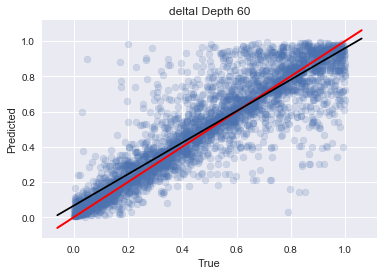

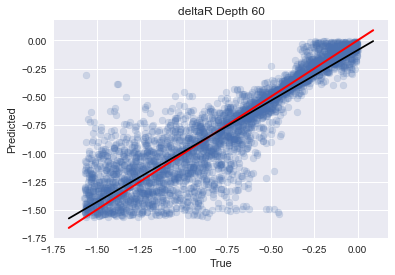

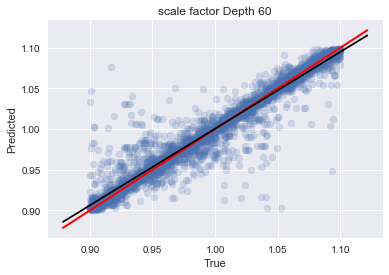

In [12]:
#Initialize the model
rs = 42
regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_sp = regr_DT_sp.fit(X1_train, Y1_train)

#print(data1[data1['Regr - DT']>0.001]) # feature importances 

#Use model to predict
predictions_DT_sp = regr_DT_sp.predict(X1_test)

#Plot results
plotSummary(Y1_test['deltaI'], predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
plotSummary(Y1_test['scale factor'], predictions_DT_sp[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [13]:
# spec info decision tree feature importances 
FI_sp_DT = pd.DataFrame(regr_DT_sp.feature_importances_.T, columns = ['Spec - DT'])
FI_sp_DT.index = X1_train.columns

#print(FI_sp_DT[FI_sp_DT['Spec - DT']>0.001])
features_sp_DT = (FI_sp_DT[FI_sp_DT['Spec - DT']>0.006])
features_sp_DT_sorted = features_sp_DT.sort_values('Spec - DT', ascending = False)

### peak info

 
RMSE on test data: 0.06670977617967358 for  deltaI Depth 60
R^2 Score on test data: 0.9455012060735407 for deltaI Depth 60
 
RMSE on test data: 0.1381318425203258 for  deltaR Depth 60
R^2 Score on test data: 0.9077471047303188 for deltaR Depth 60
 
RMSE on test data: 0.027581624757618283 for  scale factor Depth 60
R^2 Score on test data: 0.7722863476166532 for scale factor Depth 60


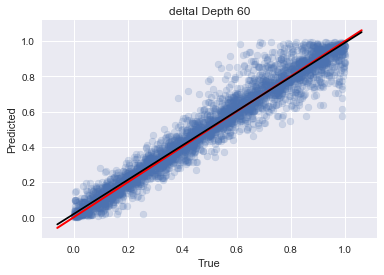

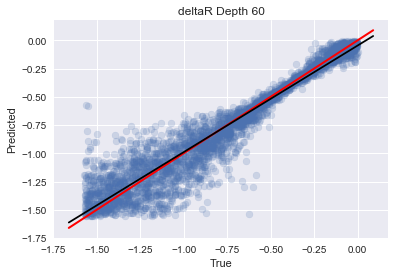

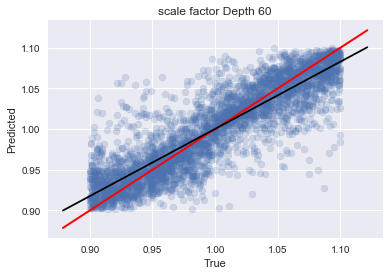

In [14]:
#Initialize the model
rs = 42
regr_DT_pi = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_pi.fit(X2_train, Y2_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
predictions_DT_pi = regr_DT_pi.predict(X2_test)

#Plot results
plotSummary(Y2_test['deltaI'], predictions_DT_pi[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y2_test['deltaR'], predictions_DT_pi[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
plotSummary(Y2_test['scale factor'], predictions_DT_pi[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [15]:
# peak info decision tree feature importances 
FI_pi_DT = pd.DataFrame(regr_DT_pi.feature_importances_.T, columns = ['Peak - DT'])
FI_pi_DT.index = X2_train.columns

#print(FI_pi_DT[FI_sp_DT['Peak - DT']>0.001])
features_pi_DT = (FI_pi_DT[FI_pi_DT['Peak - DT']>0.006])
features_pi_DT_sorted = features_pi_DT.sort_values('Peak - DT', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.08154606319446026 for  deltaI Depth 60
R^2 Score on test data: 0.9185644707736291 for deltaI Depth 60
 
RMSE on test data: 0.15953310934282744 for  deltaR Depth 60
R^2 Score on test data: 0.8769464761839636 for deltaR Depth 60
 
RMSE on test data: 0.03255914699348975 for  scale factor Depth 60
R^2 Score on test data: 0.6826814839395299 for scale factor Depth 60


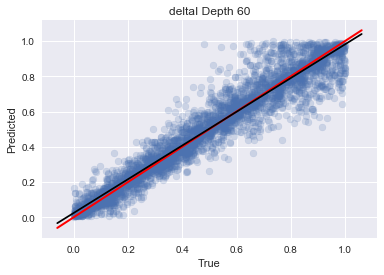

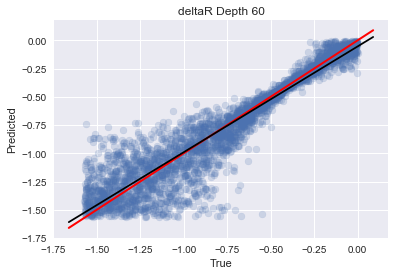

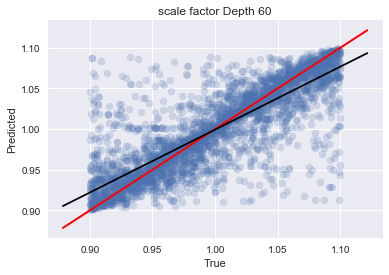

In [16]:
#Initialize the model
rs = 42
regr_DT_both = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_both.fit(X_train, Y_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
predictions_DT_both = regr_DT_both.predict(X_test)

#Plot results
plotSummary(Y_test['deltaI'], predictions_DT_both[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], predictions_DT_both[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
plotSummary(Y_test['scale factor'], predictions_DT_both[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [17]:
# combined info decision tree feature importances 
FI_b_DT = pd.DataFrame(regr_DT_both.feature_importances_.T, columns = ['Both - DT'])
FI_b_DT.index = X_train.columns

#print(FI_b_DT[FI_b_DT['Both - DT']>0.001])
features_b_DT = (FI_b_DT[FI_b_DT['Both - DT']>0.006])
features_b_DT_sorted = features_b_DT.sort_values('Both - DT', ascending = False)

In [18]:
display_side_by_side(features_sp_DT_sorted, features_b_DT_sorted, features_pi_DT_sorted,)

,Spec - DT
E_-300_mV,0.458879
E_-234_mV,0.134324
E_-232_mV,0.022606
E_-68_mV,0.019062
E_182_mV,0.016202
E_-186_mV,0.013991
E_-298_mV,0.007909
E_248_mV,0.007692
E_30_mV,0.006576
,Both - DT


## Random Forest

### spec points

 
RMSE on test data: 0.0932835783272255 for  deltaI RF spec
R^2 Score on test data: 0.8934340849381233 for deltaI RF spec
 
RMSE on test data: 0.14533435467431546 for  deltaR RF spec
R^2 Score on test data: 0.8978757292269509 for deltaR RF spec
 
RMSE on test data: 0.007256466198076663 for  scale factor RF spec
R^2 Score on test data: 0.984238420714812 for scale factor RF spec


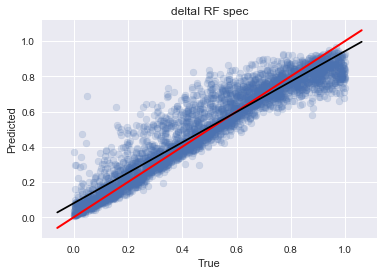

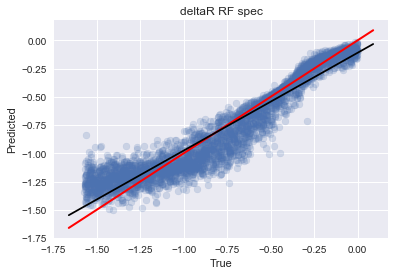

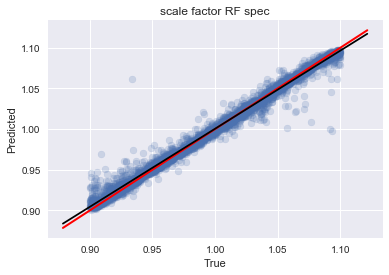

In [19]:
rs = 42
regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_sp = regr_RF_sp.fit(X1_train, Y1_train)

predictions_RF_sp = model_RF_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_RF_sp[:,0], 'deltaI RF spec')
plotSummary(Y1_test['deltaR'], predictions_RF_sp[:,1], 'deltaR RF spec')
plotSummary(Y1_test['scale factor'], predictions_RF_sp[:,2], 'scale factor RF spec')

In [20]:
# spec info random forest feature importances 
FI_sp_RF = pd.DataFrame(regr_RF_sp.feature_importances_.T, columns = ['Spec - RF'])
FI_sp_RF.index = X1_train.columns

#print(FI_sp_RF[FI_sp_RF['Spec - RF']>0.001])
features_sp_RF = (FI_sp_RF[FI_sp_RF['Spec - RF']>0.006])
features_sp_RF_sorted = features_sp_RF.sort_values('Spec - RF', ascending = False)

### peak info

 
RMSE on test data: 0.047578336987278966 for  deltaI RF PI
R^2 Score on test data: 0.9722778799265408 for deltaI RF PI
 
RMSE on test data: 0.10318903634554918 for  deltaR RF PI
R^2 Score on test data: 0.9485175141605221 for deltaR RF PI
 
RMSE on test data: 0.013414866840155018 for  scale factor RF PI
R^2 Score on test data: 0.9461330842426172 for scale factor RF PI


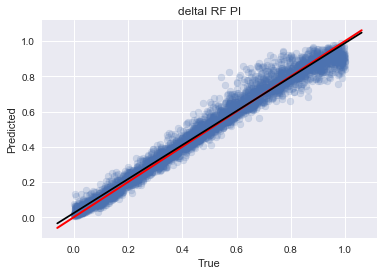

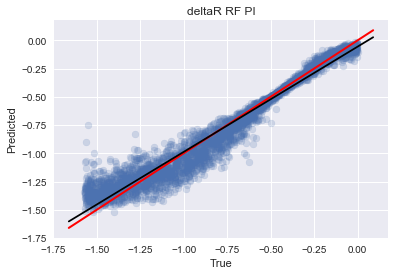

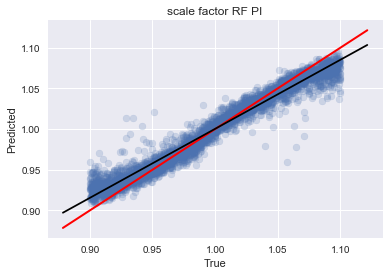

In [21]:
rs = 42
regr_RF_pi = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_pi = regr_RF_pi.fit(X2_train, Y2_train)

predictions_RF_pi = model_RF_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_RF_pi[:,0], 'deltaI RF PI')
plotSummary(Y2_test['deltaR'], predictions_RF_pi[:,1], 'deltaR RF PI')
plotSummary(Y2_test['scale factor'], predictions_RF_pi[:,2], 'scale factor RF PI')

In [22]:
# peak info random forest feature importances 
FI_pi_RF = pd.DataFrame(regr_RF_pi.feature_importances_.T, columns = ['Peak - RF'])
FI_pi_RF.index = X2_train.columns

#print(FI_pi_RF[FI_sp_RF['Peak - RF']>0.001])
features_pi_RF = (FI_pi_RF[FI_pi_RF['Peak - RF']>0.006])
features_pi_RF_sorted = features_pi_RF.sort_values('Peak - RF', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.05778610459749492 for  deltaI RF Combo
R^2 Score on test data: 0.9591064547711435 for deltaI RF Combo
 
RMSE on test data: 0.11794148917240321 for  deltaR RF Combo
R^2 Score on test data: 0.9327448401324284 for deltaR RF Combo
 
RMSE on test data: 0.013909583265794872 for  scale factor RF Combo
R^2 Score on test data: 0.9420867930043747 for scale factor RF Combo


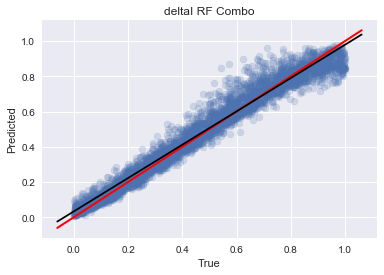

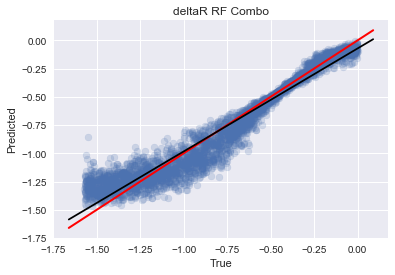

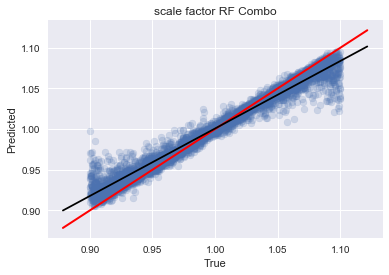

In [23]:
rs = 42
regr_RF_both = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_both = regr_RF_both.fit(X_train, Y_train)

predictions_RF_both = model_RF_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_RF_both[:,0], 'deltaI RF Combo')
plotSummary(Y_test['deltaR'], predictions_RF_both[:,1], 'deltaR RF Combo')
plotSummary(Y_test['scale factor'], predictions_RF_both[:,2], 'scale factor RF Combo')

In [24]:
# combined info decision tree feature importances 
FI_b_RF = pd.DataFrame(regr_RF_both.feature_importances_.T, columns = ['Both - RF'])
FI_b_RF.index = X_train.columns

#print(FI_b_RF[FI_b_RF['Both - RF']>0.001])
features_b_RF = (FI_b_RF[FI_b_RF['Both - RF']>0.006])
features_b_RF_sorted = features_b_RF.sort_values('Both - RF', ascending = False)

In [25]:
display_side_by_side(features_pi_RF_sorted, features_sp_RF_sorted, features_b_RF_sorted)

,Peak - RF
peak4,0.611674
peak2,0.197735
prom4,0.063713
width2,0.035711
prom3,0.025729
prom2,0.018435
peak3,0.016429
width4,0.010941
width3,0.009410
,Spec - RF


## Independent Random Forests

### spec points


Score - Random Forest: 0.9100978343497537 for deltaR IRF
 
RMSE on test data: 0.13636059235163545 for  deltaR 10
R^2 Score on test data: 0.9100978343497537 for deltaR 10
 
RMSE on test data: 0.08285788624450674 for  deltaI 10
R^2 Score on test data: 0.9159233064141841 for deltaI 10
 
RMSE on test data: 0.0050437148460110125 for  scale factor IRF
R^2 Score on test data: 0.9923853415525501 for scale factor IRF


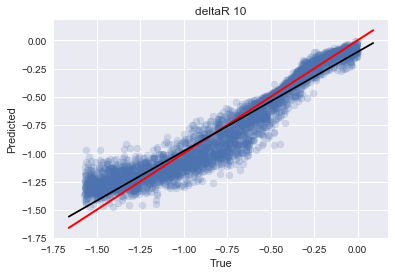

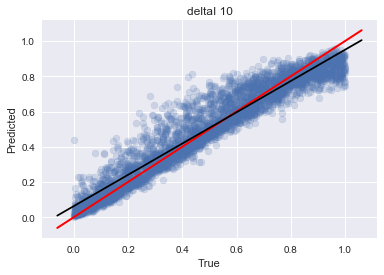

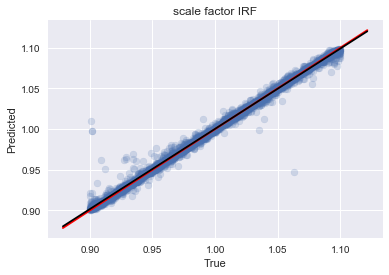

In [26]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_sf_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_sp = regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_RF2_di_sp = regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])
model_RF2_sf_sp = regr_RF2_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_RF2_dr_sp = model_RF2_dr_sp.predict(X1_test)
predictions_RF2_di_sp = model_RF2_di_sp.predict(X1_test)
predictions_RF2_sf_sp = model_RF2_sf_sp.predict(X1_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_sp.score(X1_test, Y1_test['deltaR']), 'for deltaR IRF')

plotSummary(Y1_test['deltaR'], predictions_RF2_dr_sp, 'deltaR 10')
plotSummary(Y1_test['deltaI'], predictions_RF2_di_sp, 'deltaI 10')
plotSummary(Y1_test['scale factor'], predictions_RF2_sf_sp, 'scale factor IRF')

In [27]:
# spec info independent random forest feature importances delta R  
FI_sp_RF2_dr = pd.DataFrame(model_RF2_dr_sp.feature_importances_.T, columns = ['Spec - RF2_dr'])
FI_sp_RF2_dr.index = X1_train.columns

# print(FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.001])
features_sp_RF2_dr = (FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.006])
features_sp_RF2_dr_sorted = features_sp_RF2_dr.sort_values('Spec - RF2_dr', ascending = False)

# spec info independent random forest feature importances delta I  
FI_sp_RF2_di = pd.DataFrame(model_RF2_di_sp.feature_importances_.T, columns = ['Spec - RF2_di'])
FI_sp_RF2_di.index = X1_train.columns

# print(FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.001])
features_sp_RF2_di = (FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.006])
features_sp_RF2_di_sorted = features_sp_RF2_di.sort_values('Spec - RF2_di', ascending = False)

# spec info independent random forest feature importances scale factor 
FI_sp_RF2_sf = pd.DataFrame(model_RF2_sf_sp.feature_importances_.T, columns = ['Spec - RF2_sf'])
FI_sp_RF2_sf.index = X1_train.columns

# print(FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.001])
features_sp_RF2_sf = (FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.006])
features_sp_RF2_sf_sorted = features_sp_RF2_sf.sort_values('Spec - RF2_sf', ascending = False)

### peak info


Score - Random Forest: 0.9454729772824169 for delta R IRF PI
 
RMSE on test data: 0.10619637559885327 for  deltaI IRF PI
R^2 Score on test data: 0.9454729772824169 for deltaI IRF PI
 
RMSE on test data: 0.04609023150399489 for  deltaR IRF PI
R^2 Score on test data: 0.9739848878000587 for deltaR IRF PI
 
RMSE on test data: 0.0054882520306747075 for  scale factor IRF PI
R^2 Score on test data: 0.9909839259219354 for scale factor IRF PI


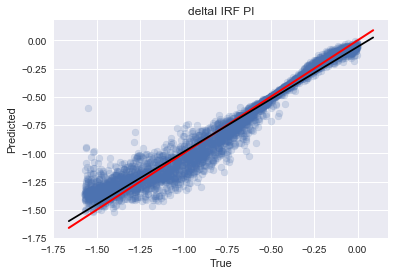

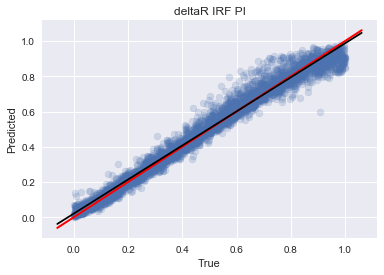

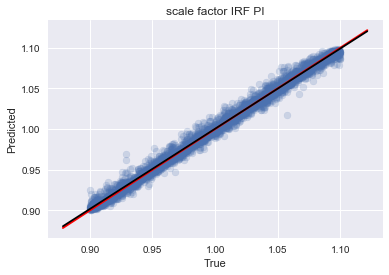

In [28]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_sf_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_pi = regr_RF2_dr_pi.fit(X2_train, Y2_train['deltaR'])
model_RF2_di_pi = regr_RF2_di_pi.fit(X2_train, Y2_train['deltaI'])
model_RF2_sf_pi = regr_RF2_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_RF2_dr_pi = model_RF2_dr_pi.predict(X2_test)
predictions_RF2_di_pi = model_RF2_di_pi.predict(X2_test)
predictions_RF2_sf_pi = model_RF2_sf_pi.predict(X2_test)


#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_pi.score(X2_test, Y2_test['deltaR']), 'for delta R IRF PI')

plotSummary(Y2_test['deltaR'], predictions_RF2_dr_pi, 'deltaI IRF PI')
plotSummary(Y2_test['deltaI'], predictions_RF2_di_pi, 'deltaR IRF PI')
plotSummary(Y2_test['scale factor'], predictions_RF2_sf_pi, 'scale factor IRF PI')

In [29]:
# peak info independent random forest feature importances delta R  
FI_pi_RF2_dr = pd.DataFrame(model_RF2_dr_pi.feature_importances_.T, columns = ['Peak - RF2_dr'])
FI_pi_RF2_dr.index = X2_train.columns

# print(FI_pi_RF2_dr[FI_pi_RF2_dr['Peak - RF2_dr']>0.001])
features_pi_RF2_dr = (FI_pi_RF2_dr[FI_pi_RF2_dr['Peak - RF2_dr']>0.006])
features_pi_RF2_dr_sorted = features_pi_RF2_dr.sort_values('Peak - RF2_dr', ascending = False)


# peak info independent random forest feature importances delta I 
FI_pi_RF2_di = pd.DataFrame(model_RF2_di_pi.feature_importances_.T, columns = ['Peak - RF2_di'])
FI_pi_RF2_di.index = X2_train.columns

# print(FI_pi_RF2_di[FI_pi_RF2_di['Peak - RF2_di']>0.001])
features_pi_RF2_di = (FI_pi_RF2_di[FI_pi_RF2_di['Peak - RF2_di']>0.006])
features_pi_RF2_di_sorted = features_pi_RF2_di.sort_values('Peak - RF2_di', ascending = False)

# peak info independent random forest feature importances scale factor
FI_pi_RF2_sf = pd.DataFrame(model_RF2_sf_pi.feature_importances_.T, columns = ['Peak - RF2_sf'])
FI_pi_RF2_sf.index = X2_train.columns

# print(FI_pi_RF2_sf[FI_pi_RF2_sf['Peak - RF2_sf']>0.001])
features_pi_RF2_sf = (FI_pi_RF2_sf[FI_pi_RF2_sf['Peak - RF2_sf']>0.006])
features_pi_RF2_sf_sorted = features_pi_RF2_sf.sort_values('Peak - RF2_sf', ascending = False)


### spec points and peak info


Score - Random Forest: 0.9201502962115038 for delta R IRF Both
 
RMSE on test data: 0.12851104557824547 for  deltaI 10
R^2 Score on test data: 0.9201502962115038 for deltaI 10
 
RMSE on test data: 0.0603181196838118 for  deltaR 10
R^2 Score on test data: 0.9554442751237775 for deltaR 10
 
RMSE on test data: 0.004328362576745587 for  deltaR IRF Both
R^2 Score on test data: 0.9943921466921035 for deltaR IRF Both


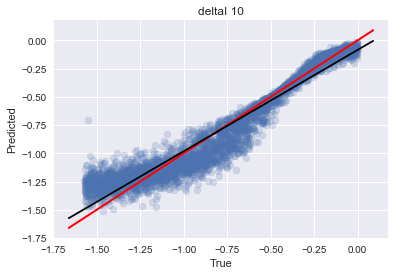

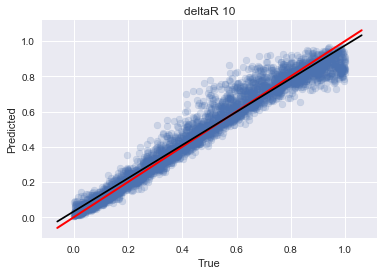

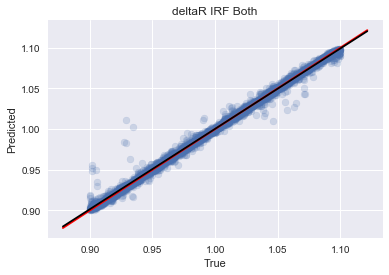

In [30]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_sf_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_both = regr_RF2_dr_both.fit(X_train, Y_train['deltaR'])
model_RF2_di_both = regr_RF2_di_both.fit(X_train, Y_train['deltaI'])
model_RF2_sf_both = regr_RF2_sf_both.fit(X_train, Y_train['scale factor'])

predictions_RF2_dr_both = model_RF2_dr_both.predict(X_test)
predictions_RF2_di_both = model_RF2_di_both.predict(X_test)
predictions_RF2_sf_both = model_RF2_sf_both.predict(X_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_both.score(X_test, Y_test['deltaR']), 'for delta R IRF Both')

plotSummary(Y_test['deltaR'], predictions_RF2_dr_both, 'deltaI 10')
plotSummary(Y_test['deltaI'], predictions_RF2_di_both, 'deltaR 10')
plotSummary(Y_test['scale factor'], predictions_RF2_sf_both, 'deltaR IRF Both')

In [31]:
# combined info independent random forest feature importances delta R  
FI_b_RF2_dr = pd.DataFrame(model_RF2_dr_both.feature_importances_.T, columns = ['Both - RF2_dr'])
FI_b_RF2_dr.index = X_train.columns

# print(FI_b_RF2_dr[FI_b_RF2_dr['Both - RF2_dr']>0.001])
features_b_RF2_dr = (FI_b_RF2_dr[FI_b_RF2_dr['Both - RF2_dr']>0.006])
features_b_RF2_dr_sorted = features_b_RF2_dr.sort_values('Both - RF2_dr', ascending = False)


# combined info independent random forest feature importances delta I  
FI_b_RF2_di = pd.DataFrame(model_RF2_di_both.feature_importances_.T, columns = ['Both - RF2_di'])
FI_b_RF2_di.index = X_train.columns

# print(FI_b_RF2_di[FI_b_RF2_di['Both - RF2_di']>0.001])
features_b_RF2_di = (FI_b_RF2_di[FI_b_RF2_di['Both - RF2_di']>0.006])
features_b_RF2_di_sorted = features_b_RF2_di.sort_values('Both - RF2_di', ascending = False)

# combined info independent random forest feature importances scale factor 
FI_b_RF2_sf = pd.DataFrame(model_RF2_sf_both.feature_importances_.T, columns = ['Both - RF2_sf'])
FI_b_RF2_sf.index = X_train.columns

# print(FI_b_RF2_sf[FI_b_RF2_sf['Both - RF2_sf']>0.001])
features_b_RF2_sf = (FI_b_RF2_sf[FI_b_RF2_sf['Both - RF2_sf']>0.006])
features_b_RF2_sf_sorted = features_b_RF2_sf.sort_values('Both - RF2_sf', ascending = False)

In [32]:

display_side_by_side(features_sp_RF2_dr_sorted, features_sp_RF2_di_sorted, features_sp_RF2_sf_sorted, features_b_RF2_dr_sorted, features_b_RF2_di_sorted, features_b_RF2_sf_sorted)
display_side_by_side(features_pi_RF2_dr_sorted, features_pi_RF2_di_sorted, features_pi_RF2_sf_sorted)

,Spec - RF2_dr
E_-300_mV,0.438928
E_-234_mV,0.144323
E_-184_mV,0.025964
E_-68_mV,0.021165
E_-66_mV,0.011791
E_-298_mV,0.011311
E_-182_mV,0.010720
E_-186_mV,0.009866
,Spec - RF2_di
E_-300_mV,0.521300


,Peak - RF2_dr
peak4,0.636185
prom4,0.124892
prom3,0.059737
peak2,0.037829
peak3,0.035584
width2,0.033114
prom2,0.023787
width4,0.020769
width3,0.010978
loc2,0.010693


## AdaBoost Random Forest

### spec points

 
RMSE on test data: 0.08158764415891043 for  AdaBoost Delta I SP
R^2 Score on test data: 0.9184814003952548 for AdaBoost Delta I SP
 
RMSE on test data: 0.13377802229022792 for  AdaBoost Delta R SP
R^2 Score on test data: 0.9134709495661185 for AdaBoost Delta R SP
 
RMSE on test data: 0.003557211432164235 for  AdaBoost Scale Factor SP
R^2 Score on test data: 0.9962123596318847 for AdaBoost Scale Factor SP
Delta I AdaBoost Score: 0.9184814003952549
Delta R AdaBoost Score: 0.9134709495661185
Scale Factor AdaBoost Score: 0.9962123596318846


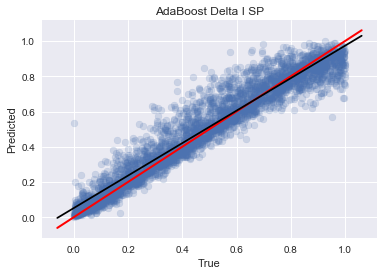

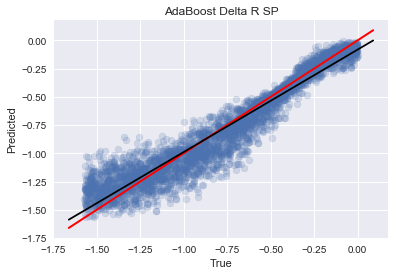

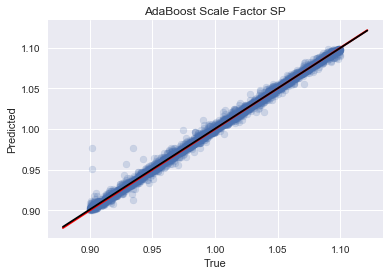

In [33]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
regr_AB_sf_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_sp = regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_AB_dr_sp = regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_AB_sf_sp = regr_AB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_AB_di_sp = model_AB_di_sp.predict(X1_test)
predictions_AB_dr_sp = model_AB_dr_sp.predict(X1_test)
predictions_AB_sf_sp = model_AB_sf_sp.predict(X1_test)


plotSummary(Y1_test['deltaI'], predictions_AB_di_sp, 'AdaBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_AB_dr_sp, 'AdaBoost Delta R SP')
plotSummary(Y1_test['scale factor'], predictions_AB_sf_sp, 'AdaBoost Scale Factor SP')

print('Delta I AdaBoost Score:', model_AB_di_sp.score(X1_test, Y1_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_dr_sp.score(X1_test, Y1_test['deltaR']))
print('Scale Factor AdaBoost Score:', model_AB_sf_sp.score(X1_test, Y1_test['scale factor']))


In [34]:
# spec info adaboost random forest feature importances delta R  
FI_sp_AB_dr = pd.DataFrame(model_AB_dr_sp.feature_importances_.T, columns = ['Spec - AB_dr'])
FI_sp_AB_dr.index = X1_train.columns

# print(FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.001])
features_sp_AB_dr = (FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.006])
features_sp_AB_dr_sorted = features_sp_AB_dr.sort_values('Spec - AB_dr', ascending = False)

# spec info adaboost random forest feature importances delta I  
FI_sp_AB_di = pd.DataFrame(model_AB_di_sp.feature_importances_.T, columns = ['Spec - AB_di'])
FI_sp_AB_di.index = X1_train.columns

# print(FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.001])
features_sp_AB_di = (FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.006])
features_sp_AB_di_sorted = features_sp_AB_di.sort_values('Spec - AB_di', ascending = False)

# spec info adaboost random forest feature importances scale factor 
FI_sp_AB_sf = pd.DataFrame(model_AB_sf_sp.feature_importances_.T, columns = ['Spec - AB_sf'])
FI_sp_AB_sf.index = X1_train.columns

# print(FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.001])
features_sp_AB_sf = (FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.006])
features_sp_AB_sf_sorted = features_sp_AB_sf.sort_values('Spec - AB_sf', ascending = False)

### peak info

 
RMSE on test data: 0.0487849441358977 for  AdaBoost Delta I PI
R^2 Score on test data: 0.970853960558388 for AdaBoost Delta I PI
 
RMSE on test data: 0.1083549352880984 for  AdaBoost Delta R PI
R^2 Score on test data: 0.9432338043787251 for AdaBoost Delta R PI
 
RMSE on test data: 0.0060166345261376195 for  AdaBoost Scale Factor PI
R^2 Score on test data: 0.9891643082746232 for AdaBoost Scale Factor PI


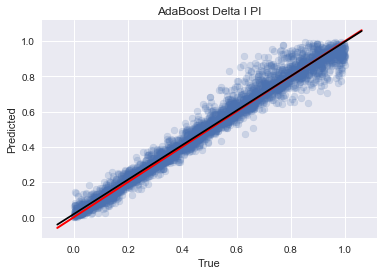

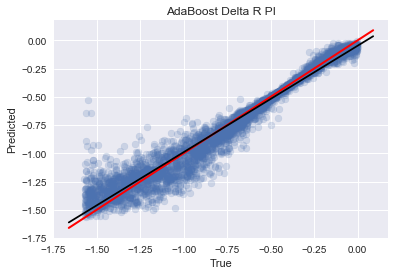

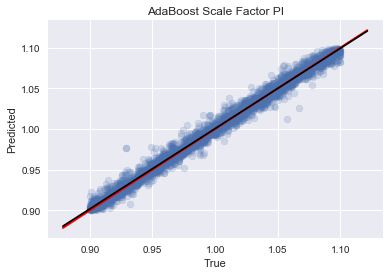

In [35]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
regr_AB_sf_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_pi = regr_AB_di_pi.fit(X2_train, Y2_train['deltaI'])
model_AB_dr_pi = regr_AB_dr_pi.fit(X2_train, Y2_train['deltaR'])
model_AB_sf_pi = regr_AB_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_AB_di_pi = model_AB_di_pi.predict(X2_test)
predictions_AB_dr_pi = model_AB_dr_pi.predict(X2_test)
predictions_AB_sf_pi = model_AB_sf_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_AB_di_pi, 'AdaBoost Delta I PI')
plotSummary(Y2_test['deltaR'], predictions_AB_dr_pi, 'AdaBoost Delta R PI')
plotSummary(Y2_test['scale factor'], predictions_AB_sf_pi, 'AdaBoost Scale Factor PI')

In [36]:
# peak info adaboost random forest feature importances delta R  
FI_pi_AB_dr = pd.DataFrame(model_AB_dr_pi.feature_importances_.T, columns = ['Peak - AB_dr'])
FI_pi_AB_dr.index = X2_train.columns

# print(FI_pi_AB_dr[FI_pi_AB_dr['Peak - AB_dr']>0.001])
features_pi_AB_dr = (FI_pi_AB_dr[FI_pi_AB_dr['Peak - AB_dr']>0.006])
features_pi_AB_dr_sorted = features_pi_AB_dr.sort_values('Peak - AB_dr', ascending = False)


# peak info adaboost random forest feature importances delta I 
FI_pi_AB_di = pd.DataFrame(model_AB_di_pi.feature_importances_.T, columns = ['Peak - AB_di'])
FI_pi_AB_di.index = X2_train.columns

# print(FI_pi_AB_di[FI_pi_AB_di['Peak - AB_di']>0.001])
features_pi_AB_di = (FI_pi_AB_di[FI_pi_AB_di['Peak - AB_di']>0.006])
features_pi_AB_di_sorted = features_pi_AB_di.sort_values('Peak - AB_di', ascending = False)

# peak info adaboost random forest feature importances scale factor
FI_pi_AB_sf = pd.DataFrame(model_AB_sf_pi.feature_importances_.T, columns = ['Peak - AB_sf'])
FI_pi_AB_sf.index = X2_train.columns

# print(FI_pi_AB_sf[FI_pi_AB_sf['Peak - AB_sf']>0.001])
features_pi_AB_sf = (FI_pi_AB_sf[FI_pi_AB_sf['Peak - AB_sf']>0.006])
features_pi_AB_sf_sorted = features_pi_AB_sf.sort_values('Peak - AB_sf', ascending = False)


### spec points and peak info

 
RMSE on test data: 0.06501395438541645 for  AdaBoost Delta I Combo
R^2 Score on test data: 0.9482368033241497 for AdaBoost Delta I Combo
 
RMSE on test data: 0.1287617774857935 for  AdaBoost Delta R Combo
R^2 Score on test data: 0.9198384101887995 for AdaBoost Delta R Combo
 
RMSE on test data: 0.005058482895132594 for  AdaBoost Scale Factor Combo
R^2 Score on test data: 0.992340684673183 for AdaBoost Scale Factor Combo


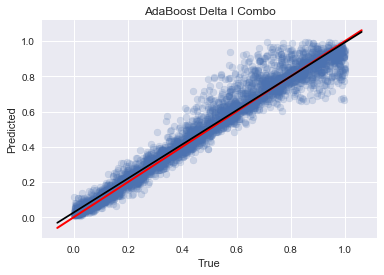

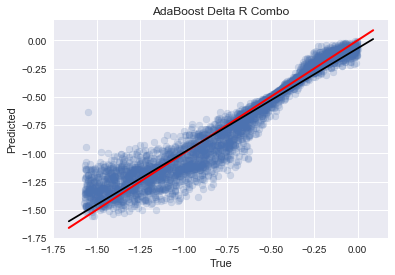

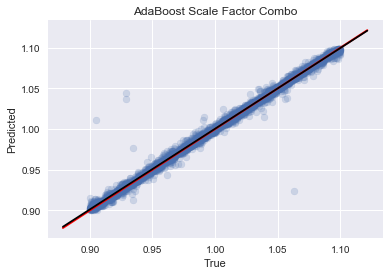

In [37]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
regr_AB_sf_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_both = regr_AB_di_both.fit(X_train, Y_train['deltaI'])
model_AB_dr_both = regr_AB_dr_both.fit(X_train, Y_train['deltaR'])
model_AB_sf_both = regr_AB_sf_both.fit(X_train, Y_train['scale factor'])

predictions_AB_di_both = model_AB_di_both.predict(X_test)
predictions_AB_dr_both = model_AB_dr_both.predict(X_test)
predictions_AB_sf_both = model_AB_sf_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_AB_di_both, 'AdaBoost Delta I Combo')
plotSummary(Y_test['deltaR'], predictions_AB_dr_both, 'AdaBoost Delta R Combo')
plotSummary(Y_test['scale factor'], predictions_AB_sf_both, 'AdaBoost Scale Factor Combo')

In [38]:
# combined info adaboost random forest feature importances delta R  
FI_b_AB_dr = pd.DataFrame(model_AB_dr_both.feature_importances_.T, columns = ['Both - AB_dr'])
FI_b_AB_dr.index = X_train.columns

# print(FI_b_AB_dr[FI_b_AB_dr['Both - AB_dr']>0.001])
features_b_AB_dr = (FI_b_AB_dr[FI_b_AB_dr['Both - AB_dr']>0.006])
features_b_AB_dr_sorted = features_b_AB_dr.sort_values('Both - AB_dr', ascending = False)


# combined info adaboost random forest feature importances delta I  
FI_b_AB_di = pd.DataFrame(model_AB_di_both.feature_importances_.T, columns = ['Both - AB_di'])
FI_b_AB_di.index = X_train.columns

# print(FI_b_AB_di[FI_b_AB_di['Both - AB_di']>0.001])
features_b_AB_di = (FI_b_AB_di[FI_b_AB_di['Both - AB_di']>0.006])
features_b_AB_di_sorted = features_b_AB_di.sort_values('Both - AB_di', ascending = False)

# combined info adaboost random forest feature importances scale factor 
FI_b_AB_sf = pd.DataFrame(model_AB_sf_both.feature_importances_.T, columns = ['Both - AB_sf'])
FI_b_AB_sf.index = X_train.columns

# print(FI_b_AB_sf[FI_b_AB_sf['Both - AB_sf']>0.001])
features_b_AB_sf = (FI_b_AB_sf[FI_b_AB_sf['Both - AB_sf']>0.006])
features_b_AB_sf_sorted = features_b_AB_sf.sort_values('Both - AB_sf', ascending = False)

In [39]:
display_side_by_side(features_sp_AB_dr_sorted, features_sp_AB_di_sorted, features_sp_AB_sf_sorted, features_b_AB_dr_sorted, features_b_AB_di_sorted, features_b_AB_sf_sorted)
display_side_by_side(features_pi_AB_dr_sorted, features_pi_AB_di_sorted, features_pi_AB_sf_sorted)

,Spec - AB_dr
E_-300_mV,0.274949
E_-234_mV,0.098036
E_-186_mV,0.074563
E_-184_mV,0.013712
E_-298_mV,0.007856
E_-66_mV,0.007391
E_-68_mV,0.007286
,Spec - AB_di
E_-300_mV,0.383248
E_-190_mV,0.014797


,Peak - AB_dr
peak4,0.561018
prom4,0.135187
prom3,0.065053
peak2,0.046954
peak3,0.042561
width2,0.038758
prom2,0.032778
width4,0.028232
width3,0.020413
loc2,0.011326


## Gradient Boosting Random Forest

### spec points

 
RMSE on test data: 0.10628217284565636 for  GradientBoost Delta I SP
R^2 Score on test data: 0.8616660514509329 for GradientBoost Delta I SP
 
RMSE on test data: 0.17581573527485939 for  GradientBoost Delta R SP
R^2 Score on test data: 0.8505458847949999 for GradientBoost Delta R SP
 
RMSE on test data: 0.0063951772598673995 for  GradientBoost Scale Factor SP
R^2 Score on test data: 0.9877579386646784 for GradientBoost Scale Factor SP


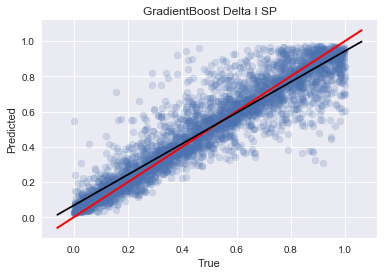

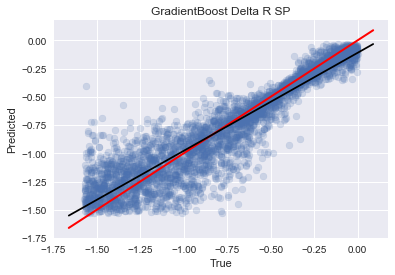

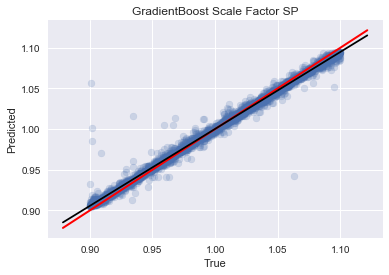

In [40]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_sf_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_sp = regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_GB_dr_sp = regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_GB_sf_sp = regr_GB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_GB_di_sp = model_GB_di_sp.predict(X1_test)
predictions_GB_dr_sp = model_GB_dr_sp.predict(X1_test)
predictions_GB_sf_sp = model_GB_sf_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_GB_di_sp, 'GradientBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_GB_dr_sp, 'GradientBoost Delta R SP')
plotSummary(Y1_test['scale factor'], predictions_GB_sf_sp, 'GradientBoost Scale Factor SP')

In [41]:
# spec info gradientboost random forest feature importances delta R  
FI_sp_GB_dr = pd.DataFrame(model_GB_dr_sp.feature_importances_.T, columns = ['Spec - GB_dr'])
FI_sp_GB_dr.index = X1_train.columns

# print(FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.001])
features_sp_GB_dr = (FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.006])
features_sp_GB_dr_sorted = features_sp_GB_dr.sort_values('Spec - GB_dr', ascending = False)

# spec info gradientboost random forest feature importances delta I  
FI_sp_GB_di = pd.DataFrame(model_GB_di_sp.feature_importances_.T, columns = ['Spec - GB_di'])
FI_sp_GB_di.index = X1_train.columns

# print(FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.001])
features_sp_GB_di = (FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.006])
features_sp_GB_di_sorted = features_sp_GB_di.sort_values('Spec - GB_di', ascending = False)

# spec info gradientboost random forest feature importances scale factor   
FI_sp_GB_sf = pd.DataFrame(model_GB_sf_sp.feature_importances_.T, columns = ['Spec - GB_sf'])
FI_sp_GB_sf.index = X1_train.columns

# print(FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.001])
features_sp_GB_sf = (FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.006])
features_sp_GB_sf_sorted = features_sp_GB_sf.sort_values('Spec - GB_sf', ascending = False)

### peak info

 
RMSE on test data: 0.0586245159195624 for  GradientBoost Delta I PI
R^2 Score on test data: 0.9579112077694418 for GradientBoost Delta I PI
 
RMSE on test data: 0.14110032580537527 for  GradientBoost Delta R PI
R^2 Score on test data: 0.9037394301321101 for GradientBoost Delta R PI
 
RMSE on test data: 0.007195926679330434 for  GradientBoost Scale Factor PI
R^2 Score on test data: 0.9845003162538912 for GradientBoost Scale Factor PI


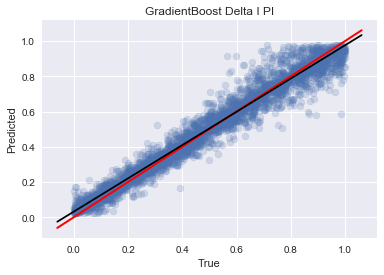

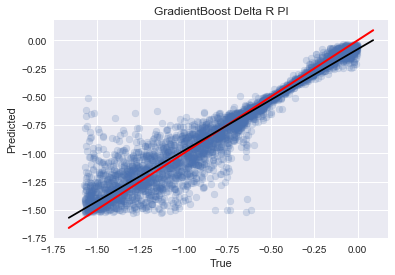

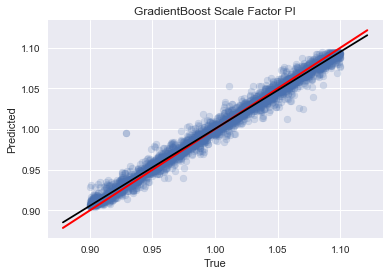

In [42]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_sf_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_pi = regr_GB_di_pi.fit(X2_train, Y2_train['deltaI'])
model_GB_dr_pi = regr_GB_dr_pi.fit(X2_train, Y2_train['deltaR'])
model_GB_sf_pi = regr_GB_sf_pi.fit(X2_train, Y2_train['scale factor'])

predictions_GB_di_pi = model_GB_di_pi.predict(X2_test)
predictions_GB_dr_pi = model_GB_dr_pi.predict(X2_test)
predictions_GB_sf_pi = model_GB_sf_pi.predict(X2_test)

plotSummary(Y2_test['deltaI'], predictions_GB_di_pi, 'GradientBoost Delta I PI')
plotSummary(Y2_test['deltaR'], predictions_GB_dr_pi, 'GradientBoost Delta R PI')
plotSummary(Y2_test['scale factor'], predictions_GB_sf_pi, 'GradientBoost Scale Factor PI')

In [43]:
# peak info gradient boost random forest feature importances delta R  
FI_pi_GB_dr = pd.DataFrame(model_GB_dr_pi.feature_importances_.T, columns = ['Peak - GB_dr'])
FI_pi_GB_dr.index = X2_train.columns

# print(FI_pi_GB_dr[FI_pi_AB_dr['Peak - GB_dr']>0.001])
features_pi_GB_dr = (FI_pi_GB_dr[FI_pi_GB_dr['Peak - GB_dr']>0.006])
features_pi_GB_dr_sorted = features_pi_GB_dr.sort_values('Peak - GB_dr', ascending = False)


# peak info gradientboost random forest feature importances delta I 
FI_pi_GB_di = pd.DataFrame(model_GB_di_pi.feature_importances_.T, columns = ['Peak - GB_di'])
FI_pi_GB_di.index = X2_train.columns

# print(FI_pi_GB_di[FI_pi_GB_di['Peak - GB_di']>0.001])
features_pi_GB_di = (FI_pi_GB_di[FI_pi_GB_di['Peak - GB_di']>0.006])
features_pi_GB_di_sorted = features_pi_GB_di.sort_values('Peak - GB_di', ascending = False)


# peak info gradientboost random forest feature importances scale factor
FI_pi_GB_sf = pd.DataFrame(model_GB_sf_pi.feature_importances_.T, columns = ['Peak - GB_sf'])
FI_pi_GB_sf.index = X2_train.columns

# print(FI_pi_GB_sf[FI_pi_GB_sf['Peak - GB_sf']>0.001])
features_pi_GB_sf = (FI_pi_GB_sf[FI_pi_GB_sf['Peak - GB_sf']>0.006])
features_pi_GB_sf_sorted = features_pi_GB_sf.sort_values('Peak - GB_sf', ascending = False)

### spec points and peak info

 
RMSE on test data: 0.07921765960087225 for  GradientBoost Delta I Combo
R^2 Score on test data: 0.9231485724277567 for GradientBoost Delta I Combo
 
RMSE on test data: 0.1655111126151247 for  GradientBoost Delta R Combo
R^2 Score on test data: 0.8675516014449691 for GradientBoost Delta R Combo
 
RMSE on test data: 0.005767993674229879 for  GradientBoost Scale Factor Combo
R^2 Score on test data: 0.9900413853266283 for GradientBoost Scale Factor Combo


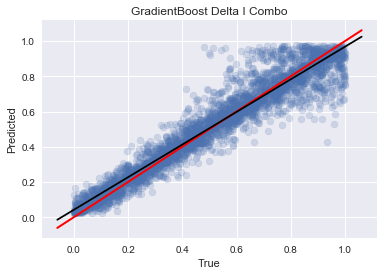

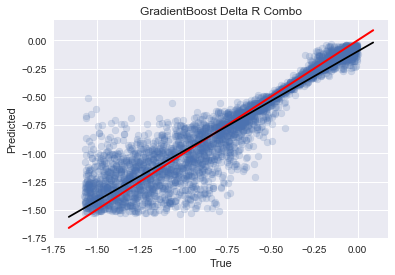

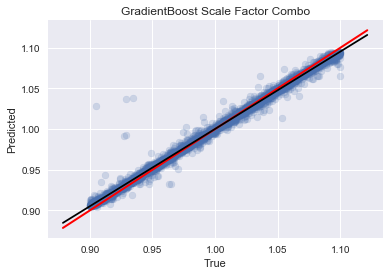

In [44]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_sf_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_both = regr_GB_di_both.fit(X_train, Y_train['deltaI'])
model_GB_dr_both = regr_GB_dr_both.fit(X_train, Y_train['deltaR'])
model_GB_sf_both = regr_GB_sf_both.fit(X_train, Y_train['scale factor'])

predictions_GB_di_both = model_GB_di_both.predict(X_test)
predictions_GB_dr_both = model_GB_dr_both.predict(X_test)
predictions_GB_sf_both = model_GB_sf_both.predict(X_test)

plotSummary(Y_test['deltaI'], predictions_GB_di_both, 'GradientBoost Delta I Combo')
plotSummary(Y_test['deltaR'], predictions_GB_dr_both, 'GradientBoost Delta R Combo')
plotSummary(Y_test['scale factor'], predictions_GB_sf_both, 'GradientBoost Scale Factor Combo')


In [45]:
# combined info gradient boost random forest feature importances delta R  
FI_b_GB_dr = pd.DataFrame(model_GB_dr_both.feature_importances_.T, columns = ['Both - GB_dr'])
FI_b_GB_dr.index = X_train.columns

# print(FI_b_GB_dr[FI_b_GB_dr['Both - GB_dr']>0.001])
features_b_GB_dr = (FI_b_GB_dr[FI_b_GB_dr['Both - GB_dr']>0.006])
features_b_GB_dr_sorted = features_b_GB_dr.sort_values('Both - GB_dr', ascending = False)


# combined info gradient boost random forest feature importances delta I  
FI_b_GB_di = pd.DataFrame(model_GB_di_both.feature_importances_.T, columns = ['Both - GB_di'])
FI_b_GB_di.index = X_train.columns

# print(FI_b_GB_di[FI_b_GB_di['Both - GB_di']>0.001])
features_b_GB_di = (FI_b_GB_di[FI_b_GB_di['Both - GB_di']>0.006])
features_b_GB_di_sorted = features_b_GB_di.sort_values('Both - GB_di', ascending = False)

# combined info gradient boost random forest feature importances scale factor 
FI_b_GB_sf = pd.DataFrame(model_GB_sf_both.feature_importances_.T, columns = ['Both - GB_sf'])
FI_b_GB_sf.index = X_train.columns

# print(FI_b_GB_sf[FI_b_GB_sf['Both - GB_sf']>0.001])
features_b_GB_sf = (FI_b_GB_sf[FI_b_GB_sf['Both - GB_sf']>0.006])
features_b_GB_sf_sorted = features_b_GB_sf.sort_values('Both - GB_sf', ascending = False)

In [46]:
display_side_by_side(features_sp_GB_dr_sorted, features_sp_GB_di_sorted,features_sp_GB_sf_sorted, features_b_GB_dr_sorted, features_b_GB_di_sorted, features_b_GB_sf_sorted)
display_side_by_side(features_pi_GB_dr_sorted, features_pi_GB_di_sorted, features_pi_GB_sf_sorted)

,Spec - GB_dr
E_-300_mV,0.440051
E_-234_mV,0.176209
E_-68_mV,0.033698
E_184_mV,0.014937
E_-186_mV,0.009861
E_-240_mV,0.009672
E_34_mV,0.008766
E_426_mV,0.007340
E_-188_mV,0.006528
E_288_mV,0.006292


,Peak - GB_dr
peak4,0.717763
prom3,0.072427
prom4,0.045421
peak2,0.041315
peak3,0.038731
width2,0.031395
prom2,0.017902
width4,0.015830
loc2,0.009163
width3,0.006227


In [47]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_dr_sorted,features_sp_AB_dr_sorted,features_sp_RF2_dr_sorted)

,Spec - RF
E_-300_mV,0.448139
E_-234_mV,0.127061
E_-232_mV,0.028379
E_-298_mV,0.015886
E_-184_mV,0.008516
E_182_mV,0.007065
,Spec - DT
E_-300_mV,0.458879
E_-234_mV,0.134324
E_-232_mV,0.022606


In [48]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_di_sorted,features_sp_AB_di_sorted,features_sp_RF2_di_sorted)

,Spec - RF
E_-300_mV,0.448139
E_-234_mV,0.127061
E_-232_mV,0.028379
E_-298_mV,0.015886
E_-184_mV,0.008516
E_182_mV,0.007065
,Spec - DT
E_-300_mV,0.458879
E_-234_mV,0.134324
E_-232_mV,0.022606


In [49]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_sf_sorted,features_sp_AB_sf_sorted,features_sp_RF2_sf_sorted)

,Spec - RF
E_-300_mV,0.448139
E_-234_mV,0.127061
E_-232_mV,0.028379
E_-298_mV,0.015886
E_-184_mV,0.008516
E_182_mV,0.007065
,Spec - DT
E_-300_mV,0.458879
E_-234_mV,0.134324
E_-232_mV,0.022606


In [50]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_dr_sorted,features_pi_AB_dr_sorted,features_pi_RF2_dr_sorted)

,Peak - RF
peak4,0.611674
peak2,0.197735
prom4,0.063713
width2,0.035711
prom3,0.025729
prom2,0.018435
peak3,0.016429
width4,0.010941
width3,0.009410
,Peak - DT


In [51]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_di_sorted,features_pi_AB_di_sorted,features_pi_RF2_di_sorted)

,Peak - RF
peak4,0.611674
peak2,0.197735
prom4,0.063713
width2,0.035711
prom3,0.025729
prom2,0.018435
peak3,0.016429
width4,0.010941
width3,0.009410
,Peak - DT


In [52]:
display_side_by_side(features_pi_RF_sorted, features_pi_DT_sorted, features_pi_GB_sf_sorted,features_pi_AB_sf_sorted,features_pi_RF2_sf_sorted)

,Peak - RF
peak4,0.611674
peak2,0.197735
prom4,0.063713
width2,0.035711
prom3,0.025729
prom2,0.018435
peak3,0.016429
width4,0.010941
width3,0.009410
,Peak - DT


In [53]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_dr_sorted,features_b_AB_dr_sorted,features_b_RF2_dr_sorted)

,Both - RF
peak4,0.601263
peak2,0.190558
prom4,0.051561
width2,0.028265
prom3,0.016050
prom2,0.014870
peak3,0.008850
,Both - DT
peak4,0.632790
peak2,0.195329


In [54]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_di_sorted,features_b_AB_di_sorted,features_b_RF2_di_sorted)

,Both - RF
peak4,0.601263
peak2,0.190558
prom4,0.051561
width2,0.028265
prom3,0.016050
prom2,0.014870
peak3,0.008850
,Both - DT
peak4,0.632790
peak2,0.195329


In [55]:
display_side_by_side(features_b_RF_sorted, features_b_DT_sorted, features_b_GB_sf_sorted,features_b_AB_sf_sorted,features_b_RF2_sf_sorted)

,Both - RF
peak4,0.601263
peak2,0.190558
prom4,0.051561
width2,0.028265
prom3,0.016050
prom2,0.014870
peak3,0.008850
,Both - DT
peak4,0.632790
peak2,0.195329


## Testing the Models on the Experimental Data



In [56]:
# Load the experimental data
col_names3 = peak_names + locs_names + width_names + prom_names
col_names4 = energy_names
col_names_exp_both = col_names_both[2:]

exp_data_sp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData180721_PS_sf_specPoints.csv', header = None, names = col_names4)
exp_data_pi = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData180721_PS_sf_peakinfo.csv', header = None, names = col_names3)

In [57]:
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
col_names1a = energy_names[50:] # use for taking out first peak specs 
exp_data_sp = exp_data_sp[col_names1a] # use for taking out first peak specs 
exp_data_sp

,E_-300_mV,E_-298_mV,E_-296_mV,E_-294_mV,E_-292_mV,E_-290_mV,E_-288_mV,E_-286_mV,E_-284_mV,E_-282_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.63866,0.64322,0.6455,0.6487,0.65752,0.66493,0.67365,0.68098,0.69691,0.70971,...,1.0453,1.0284,0.99538,0.98221,0.97146,0.97284,0.98729,0.98385,0.98191,0.97779


In [58]:
## Use these if want to remove first peak info
peak_names2 = ['peak2', 'peak3', 'peak4']
prom_names2 = ['prom2', 'prom3', 'prom4']
locs_names2 = ['loc2', 'loc3', 'loc4']
width_names2 = ['width2', 'width3', 'width4']
pi_names = peak_names2 + locs_names2 + width_names2 + prom_names2
exp_data_pi = exp_data_pi[pi_names]
exp_data_pi

,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,prom3,prom4
0,1.9262,1.8662,1.4495,-0.242,-0.074,0.134,0.032045,0.039422,0.04612,1.2902,1.1855,0.57098


In [59]:
# Use these if want to remove first peak info 
#subset = 5 
energy_names2 = energy_names[50:]
exp_data_sp2 = exp_data_sp[energy_names2]
exp_data_both = exp_data_pi.join(exp_data_sp2, how = 'left')
exp_data_both = exp_data_pi.join(exp_data_sp, how = 'left')
exp_data_both


,peak2,peak3,peak4,loc2,loc3,loc4,width2,width3,width4,prom2,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,1.9262,1.8662,1.4495,-0.242,-0.074,0.134,0.032045,0.039422,0.04612,1.2902,...,1.0453,1.0284,0.99538,0.98221,0.97146,0.97284,0.98729,0.98385,0.98191,0.97779


In [60]:
pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),
                             r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(4,1).T
pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                             r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(5,1).T
pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                             r2_score(Y1_test['scale factor'], predictions_DT_sp[:,2])).reshape(6,1).T

pred_phase_DT_pi = np.append(regr_DT_pi.predict(exp_data_pi), 
                            r2_score(Y1_test['deltaI'], predictions_DT_pi[:,0])).reshape(4,1).T
pred_phase_DT_pi = np.append(pred_phase_DT_pi, 
                            r2_score(Y1_test['deltaR'], predictions_DT_pi[:,1])).reshape(5,1).T
pred_phase_DT_pi = np.append(pred_phase_DT_pi, 
                            r2_score(Y1_test['scale factor'], predictions_DT_pi[:,2])).reshape(6,1).T

pred_phase_DT_both = np.append(regr_DT_both.predict(exp_data_both), 
                            r2_score(Y_test['deltaI'], predictions_DT_both[:,0])).reshape(4,1).T
pred_phase_DT_both = np.append(pred_phase_DT_both, 
                            r2_score(Y_test['deltaR'], predictions_DT_both[:,1])).reshape(5,1).T
pred_phase_DT_both = np.append(pred_phase_DT_both, 
                            r2_score(Y_test['scale factor'], predictions_DT_both[:,2])).reshape(6,1).T

In [61]:
pred_phase_RF_sp = regr_RF_sp.predict(exp_data_sp)
pred_phase_RF_pi = regr_RF_pi.predict(exp_data_pi)
pred_phase_RF_both = regr_RF_both.predict(exp_data_both)

pred_phase_AB_R_sp = model_AB_dr_sp.predict(exp_data_sp)
pred_phase_AB_I_sp = model_AB_di_sp.predict(exp_data_sp)
pred_phase_AB_sf_sp = model_AB_sf_sp.predict(exp_data_sp)

pred_phase_AB_R_pi = model_AB_dr_pi.predict(exp_data_pi)
pred_phase_AB_I_pi = model_AB_di_pi.predict(exp_data_pi)
pred_phase_AB_sf_pi = model_AB_sf_pi.predict(exp_data_pi)

pred_phase_AB_R_both = model_AB_dr_both.predict(exp_data_both)
pred_phase_AB_I_both = model_AB_di_both.predict(exp_data_both)
pred_phase_AB_sf_both = model_AB_sf_both.predict(exp_data_both)

pred_phase_GB_di_sp = model_GB_di_sp.predict(exp_data_sp)
pred_phase_GB_dr_sp = model_GB_dr_sp.predict(exp_data_sp)
pred_phase_GB_sf_sp = model_GB_sf_sp.predict(exp_data_sp)

pred_phase_GB_di_pi = model_GB_di_pi.predict(exp_data_pi)
pred_phase_GB_dr_pi = model_GB_dr_pi.predict(exp_data_pi)
pred_phase_GB_sf_pi = model_GB_sf_pi.predict(exp_data_pi)

pred_phase_GB_di_both = model_GB_di_both.predict(exp_data_both)
pred_phase_GB_dr_both = model_GB_dr_both.predict(exp_data_both)
pred_phase_GB_sf_both = model_GB_sf_both.predict(exp_data_both)

pred_phase_IRF_di_sp = model_RF2_di_sp.predict(exp_data_sp)
pred_phase_IRF_dr_sp = model_RF2_dr_sp.predict(exp_data_sp)
pred_phase_IRF_sf_sp = model_RF2_sf_sp.predict(exp_data_sp)

pred_phase_IRF_di_pi = model_RF2_di_pi.predict(exp_data_pi)
pred_phase_IRF_dr_pi = model_RF2_dr_pi.predict(exp_data_pi)
pred_phase_IRF_sf_pi = model_RF2_sf_pi.predict(exp_data_pi)

pred_phase_IRF_di_both = model_RF2_di_both.predict(exp_data_both)
pred_phase_IRF_dr_both = model_RF2_dr_both.predict(exp_data_both)
pred_phase_IRF_sf_both = model_RF2_sf_both.predict(exp_data_both)


In [62]:
predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score', 'scale factor', 'scale factor score'], index = ['Decision Tree spec points'])


In [63]:
new_test = pd.Series(pred_phase_DT_pi[0], index = ['deltaI', 'deltaR', 'scale factor', 'deltaI score', 'deltaR score', 'scale factor score'], name = 'Decision Tree peak info')
predictedPhases = predictedPhases.append(new_test)

In [64]:
new_1 = pd.Series(pred_phase_DT_both[0], index = ['deltaI', 'deltaR', 'scale factor', 'deltaI score', 'deltaR score', 'scale factor score'], name = 'Decision Tree spec points and peak info')
predictedPhases = predictedPhases.append(new_1)

In [65]:
RF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_sp[:,0])
RF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_sp[:,1])
RF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_sp[:,2])

RF_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_pi[:,0])
RF_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_pi[:,1])
RF_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_pi[:,2])

RF_b_di_r2score = r2_score(Y_test['deltaI'], predictions_RF_both[:,0])
RF_b_dr_r2score = r2_score(Y_test['deltaR'], predictions_RF_both[:,1])
RF_b_sf_r2score = r2_score(Y_test['scale factor'], predictions_RF_both[:,2])

In [66]:
predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], pred_phase_RF_sp[0,2], RF_sp_di_r2score, RF_sp_dr_r2score, RF_sp_sf_r2score)
predictedPhases.loc['Random Forest peak info'] = (pred_phase_RF_pi[0,0], pred_phase_RF_pi[0,1], pred_phase_RF_pi[0,2], RF_pi_di_r2score, RF_pi_dr_r2score, RF_pi_sf_r2score )
predictedPhases.loc['Random Forest spec points and peak info'] = (pred_phase_RF_both[0,0], pred_phase_RF_both[0,1], pred_phase_RF_both[0,2], RF_b_di_r2score, RF_b_dr_r2score, RF_b_sf_r2score)

In [67]:
AB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_sp)
AB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_sp)
AB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_sp)

AB_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_pi)
AB_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_pi)
AB_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_pi)

AB_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_both)
AB_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_both)
AB_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_both)

In [68]:
predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0], pred_phase_AB_sf_sp[0], AB_sp_di_r2score, AB_sp_dr_r2score, AB_sp_sf_r2score)
predictedPhases.loc['AdaBoost peak info'] = (pred_phase_AB_I_pi[0], pred_phase_AB_R_pi[0], pred_phase_AB_sf_pi[0], AB_pi_di_r2score, AB_pi_dr_r2score, AB_pi_sf_r2score) 
predictedPhases.loc['AdaBoost spec points and peak info'] = (pred_phase_AB_I_both[0], pred_phase_AB_R_both[0], pred_phase_AB_sf_both[0], AB_b_di_r2score, AB_b_dr_r2score, AB_b_sf_r2score)


In [69]:
GB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_sp)
GB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_sp)
GB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_sp)

GB_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_pi)
GB_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_pi)
GB_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_pi)

GB_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_both)
GB_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_both)
GB_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_both)

In [70]:
predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0], pred_phase_GB_sf_sp[0], GB_sp_di_r2score, GB_sp_dr_r2score, GB_sp_sf_r2score)
predictedPhases.loc['Gradient Boosting peak info'] = (pred_phase_GB_di_pi[0], pred_phase_GB_dr_pi[0], pred_phase_GB_sf_pi[0], GB_pi_di_r2score, GB_pi_dr_r2score, GB_pi_sf_r2score) 
predictedPhases.loc['Gradient Boosting spec points and peak info'] = (pred_phase_GB_di_both[0], pred_phase_GB_dr_both[0], pred_phase_GB_sf_both[0], GB_b_di_r2score, GB_b_dr_r2score, GB_b_sf_r2score)


In [71]:
IRF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_sp)
IRF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_sp)
IRF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_sp)

IRF_pi_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_pi)
IRF_pi_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_pi)
IRF_pi_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_pi)

IRF_b_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_both)
IRF_b_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_both)
IRF_b_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_both)

In [72]:
predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0],  pred_phase_IRF_sf_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score, IRF_sp_sf_r2score)
predictedPhases.loc['Independent Random Forests peak info'] = (pred_phase_IRF_di_pi[0], pred_phase_IRF_dr_pi[0],  pred_phase_IRF_sf_pi[0], IRF_pi_di_r2score, IRF_pi_dr_r2score, IRF_pi_sf_r2score)
predictedPhases.loc['Independent Random Forests spec points and peak info'] = (pred_phase_IRF_di_both[0], pred_phase_IRF_dr_both[0],  pred_phase_IRF_sf_both[0], IRF_b_di_r2score, IRF_b_dr_r2score, IRF_b_sf_r2score)

In [73]:
predictedPhases

,deltaI,deltaR,deltaI score,deltaR score,scale factor,scale factor score
Decision Tree spec points,0.167220,-0.029054,0.985770,0.783247,0.795922,0.923543
Decision Tree peak info,0.253235,-0.043974,0.945501,0.907747,0.989355,0.772286
Decision Tree spec points and peak info,0.214375,-0.047955,0.918564,0.876946,1.002140,0.682681
Random Forest spec points,0.143496,-0.064836,0.980070,0.893434,0.897876,0.984238
Random Forest peak info,0.246083,-0.067359,0.983924,0.972278,0.948518,0.946133
Random Forest spec points and peak info,0.206446,-0.075665,0.982700,0.959106,0.932745,0.942087
AdaBoost spec points,0.148830,-0.043181,0.965475,0.918481,0.913471,0.996212
AdaBoost peak info,0.243850,-0.037417,0.950980,0.970854,0.943234,0.989164
AdaBoost spec points and peak info,0.225030,-0.082248,0.958015,0.948237,0.919838,0.992341
Gradient Boosting spec points,0.109762,-0.047265,0.975753,0.861666,0.850546,0.987758


In [81]:
# Predictions with 0.95 or lower scores excluded 
GoodPredictedDeltaI = predictedPhases.drop(['Decision Tree spec points and peak info', 'Decision Tree peak info', 'Gradient Boosting peak info'], axis = 0)
GoodPredictedDeltaR = predictedPhases.drop(['Decision Tree spec points', 'Decision Tree peak info', 'Decision Tree spec points and peak info', 'Random Forest spec points', 'Gradient Boosting peak info'], axis = 0)
GoodPredictedScaleFactor = predictedPhases.drop(['Decision Tree peak info', 'Decision Tree spec points', 'Decision Tree spec points and peak info', 'Random Forest peak info', 'Random Forest spec points and peak info'], axis = 0)


deltaI_1 = (GoodPredictedDeltaI['deltaI']*GoodPredictedDeltaI['deltaI score']).mean()
deltaR_1 = (GoodPredictedDeltaR['deltaR']*GoodPredictedDeltaR['deltaR score']).mean()
scale_factor1 = (GoodPredictedScaleFactor['scale factor']*GoodPredictedScaleFactor['scale factor score']).mean()
print('The weighted average for the predicted phase is: ', deltaR_1, ' + ', deltaI_1, '*i')
print('The weighted average for the scale factor is:', scale_factor1)

The weighted average for the predicted phase is:  -0.05316361886680049  +  0.19356333090130784 *i
The weighted average for the scale factor is: 0.8983424826674803


In [75]:
predictedPhases[['deltaI', 'deltaR', 'scale factor']].to_csv('Model_Results/Hexagon/predictions_PS_sf_FI_180721.csv')
predictedPhases[['deltaI score', 'deltaR score', 'scale factor score']].to_csv('Model_Results/Hexagon/scores_PS_sf_FI_180721.csv')



In [76]:
importance_DT_ = pd.Series(regr_DT_both.feature_importances_, index = X_train.columns)
importance_DT_ = pd.Series(regr_DT_both.feature_importances_, index = X_train.columns)
importance_RF_= pd.Series(model_RF_both.feature_importances_, index = X_train.columns)
importance_IRF_r = pd.Series(model_RF2_dr_both.feature_importances_, index = X_train.columns)
importance_IRF_i = pd.Series(model_RF2_di_both.feature_importances_, index = X_train.columns)
importance_IRF_sf = pd.Series(model_RF2_sf_both.feature_importances_, index = X_train.columns)
importance_ARF_r = pd.Series(model_AB_dr_both.feature_importances_, index = X_train.columns)
importance_ARF_i = pd.Series(model_AB_di_both.feature_importances_, index = X_train.columns)
importance_ARF_sf = pd.Series(model_AB_sf_both.feature_importances_, index = X_train.columns)
importance_GRF_r = pd.Series(model_GB_dr_both.feature_importances_, index = X_train.columns)
importance_GRF_i = pd.Series(model_GB_di_both.feature_importances_, index = X_train.columns)
importance_GRF_sf = pd.Series(model_GB_sf_both.feature_importances_, index = X_train.columns)

In [77]:
#tenFeatures = linspace(0,10, 10)
DT_FI_top = importance_DT_.nlargest(10)
RF_FI_top = importance_RF_.nlargest(10)
IRF_r_FI_top = importance_IRF_r.nlargest(10)
IRF_i_FI_top = importance_IRF_i.nlargest(10)
IRF_sf_FI_top = importance_IRF_sf.nlargest(10)
ARF_r_FI_top = importance_ARF_r.nlargest(10)
ARF_i_FI_top = importance_ARF_i.nlargest(10)
ARF_sf_FI_top = importance_ARF_sf.nlargest(10)
GRF_r_FI_top = importance_GRF_r.nlargest(10)
GRF_i_FI_top = importance_GRF_i.nlargest(10)
GRF_sf_FI_top = importance_GRF_sf.nlargest(10)
tops_list = [DT_FI_top, RF_FI_top, IRF_r_FI_top,IRF_i_FI_top, ARF_r_FI_top, ARF_i_FI_top, GRF_r_FI_top, GRF_i_FI_top ]
tops = pd.concat(tops_list)
#tops.plot(kind = 'pie')
tops_count = tops.groupby(level=[0]).size()
tops_count.sort_values(axis = 0)
tops_count = tops_count.sort_values()
tops_count

E_-246_mV    1
E_288_mV     1
E_-290_mV    1
E_-286_mV    1
E_474_mV     1
E_-282_mV    1
E_-258_mV    1
E_-280_mV    2
E_-300_mV    3
width3       3
E_-284_mV    3
width4       6
peak2        8
peak3        8
peak4        8
prom2        8
prom3        8
prom4        8
width2       8
dtype: int64

In [78]:
sf_tops_list = [IRF_sf_FI_top, ARF_sf_FI_top, GRF_sf_FI_top ]
sf_tops = pd.concat(sf_tops_list)
#sf_tops.plot(kind = 'pie')
sf_tops_count = sf_tops.groupby(level=[0]).size()
sf_tops_count.sort_values(axis = 0)
sf_tops_count = sf_tops_count.sort_values()
sf_tops_count

E_-208_mV    1
E_424_mV     1
E_408_mV     1
E_220_mV     1
E_216_mV     1
E_108_mV     1
E_-278_mV    1
loc3         1
E_-270_mV    1
E_-272_mV    1
E_-246_mV    1
E_-238_mV    1
E_-236_mV    1
E_-232_mV    1
E_-22_mV     1
E_-214_mV    1
E_-212_mV    1
E_218_mV     2
E_330_mV     2
E_354_mV     2
E_-210_mV    2
E_-24_mV     2
loc4         3
dtype: int64

Text(0,0.5,'Feature Importance')

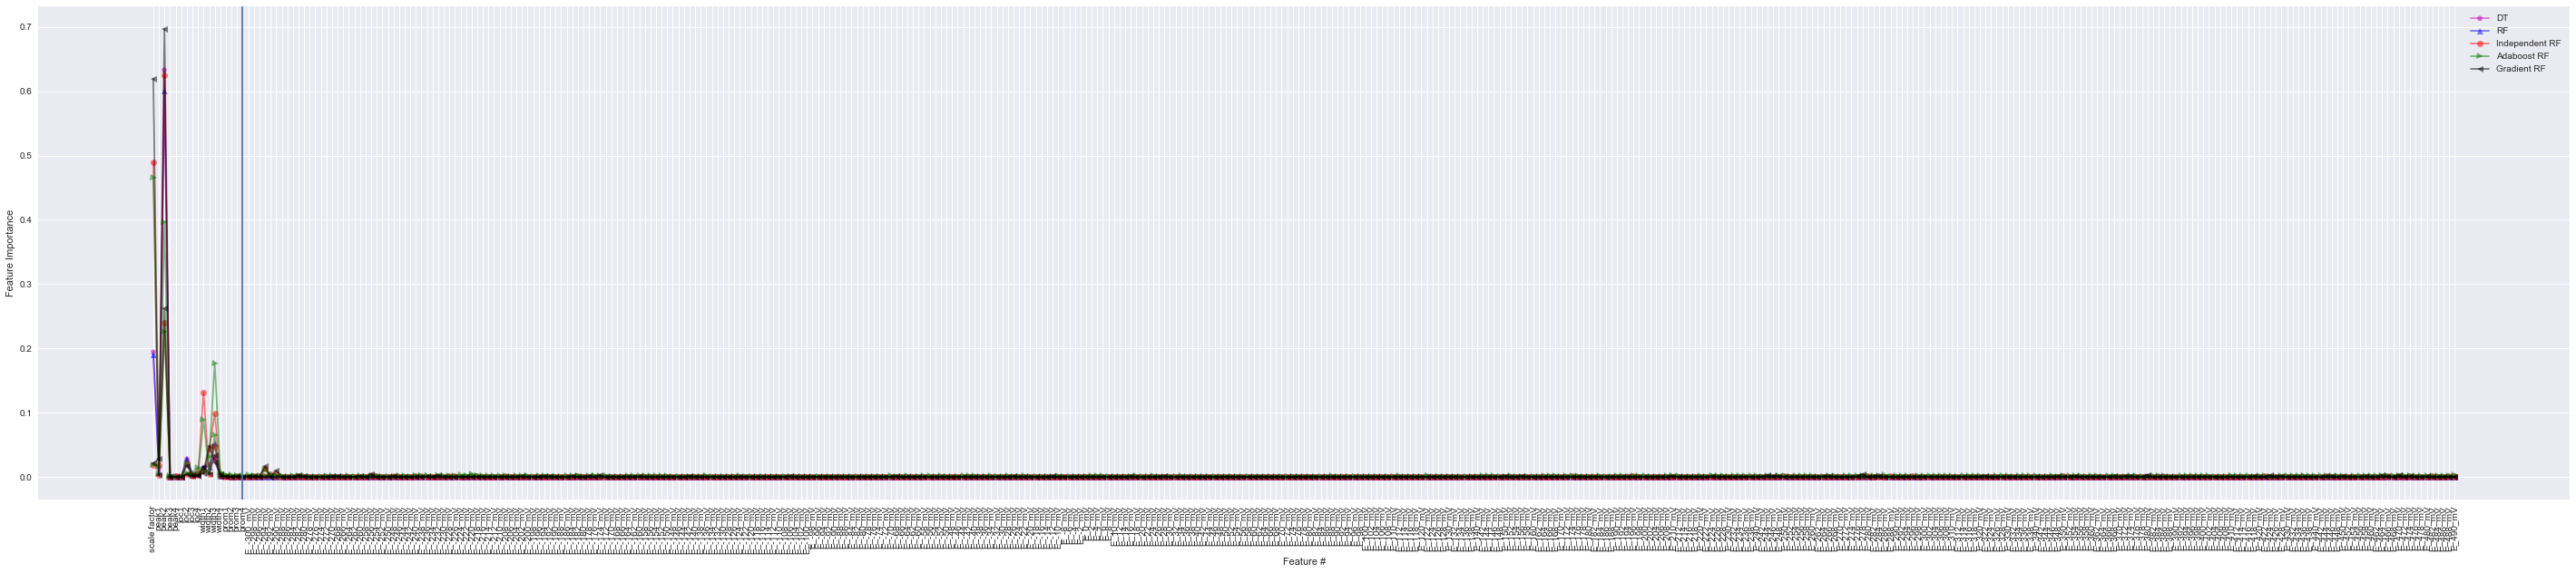

In [79]:
Features = linspace(0,413, 413)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, col_names_exp_both, rotation = 'vertical')
matplotlib.pyplot.axvline(x=16, ymin=0, ymax=1)
xlabel('Feature #')
ylabel('Feature Importance')

(0, 50)

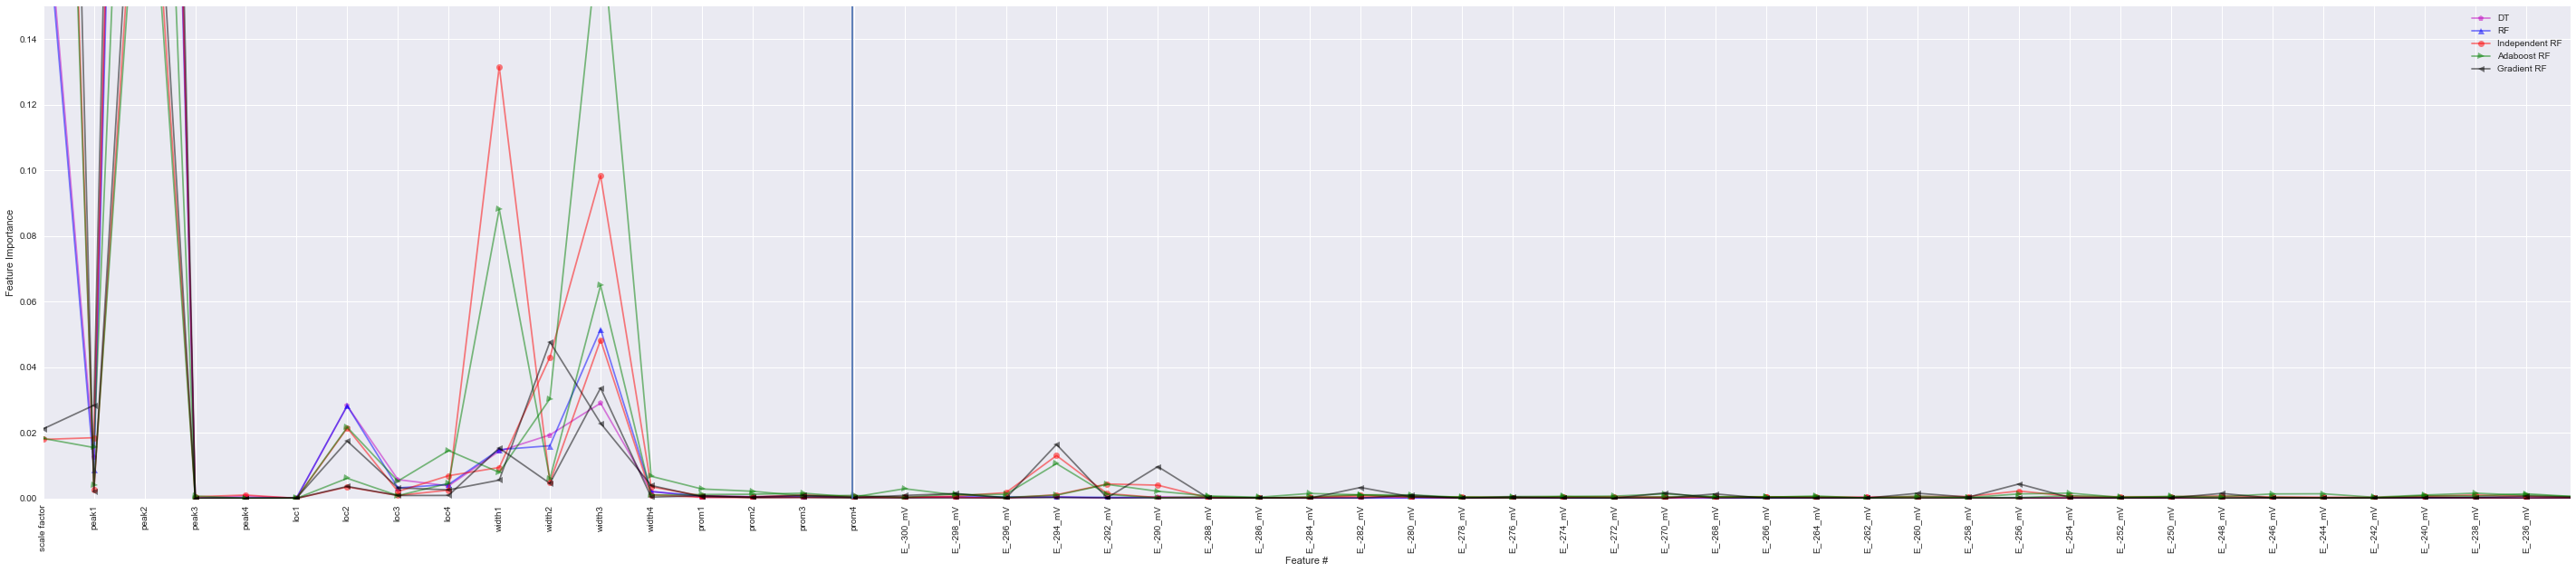

In [80]:
Features = linspace(0,413, 413)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, col_names_exp_both, rotation = 'vertical')
matplotlib.pyplot.axvline(x=16, ymin=0, ymax=1)
xlabel('Feature #')
ylabel('Feature Importance')
ylim([0, 0.15])
xlim([0, 50])